In [1]:
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D,Add,Concatenate,Softmax,Input
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
#import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math
from keras.activations import softmax,tanh
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
import numpy
le = preprocessing.LabelEncoder()

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5751236992803099978, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12281729028731650662
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7954145106461145628
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5503516672
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11195671783859731550
 physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [4]:
with open('traceability0.pckl','rb') as file:
    train_images,train_labels,test_images,test_labels = pickle.load(file)

In [5]:
class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            #self.model.save_weights(filepath, overwrite=True)
                            print("asd")
                            try:
                                with open(filepath,'wb') as f:
                                    pickle.dump(self.model.get_weights(),f)
                            except Exception as ex:
                                print("Could not write",ex)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

In [6]:
un = len(np.unique(list(train_labels)+list(test_labels)))
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder()
train_labs = le.fit_transform(train_labels)
test_labs = le.transform(test_labels)
ohe_train_labs = ohe.fit_transform(train_labs.reshape(-1,1))
ohe_test_labs = ohe.transform(test_labs.reshape(-1,1))

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [38]:
input = Input((224,224,3))

cnn_base = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    #if layer.name=='block5_conv3':
        #break
    layer.trainable = False

x = cnn_base.get_layer('block5_pool').output
x = Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(256, kernel_size=(3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
y = Dense(128,activation='relu',name='moddel')(x)
x = Dense(un,activation='softmax')(y)
base_model = Model(inputs=cnn_base.input, outputs=x)
bb_model = Model(inputs=cnn_base.input, outputs=y)


base_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
initial_weights = base_model.get_weights()

In [39]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
# base_model.get_weights()[:-1]

In [23]:
def convert_to_dict(train_images,train_labels):
    train_dict = {}
    for img,label in zip(list(train_images),list(train_labels)):
        if int(label) in train_dict:
            train_dict[int(label)].append(img)
        else:
            train_dict[int(label)] = [img]
    return train_dict

In [24]:
train_dict = convert_to_dict(train_images,train_labels)
test_dict = convert_to_dict(test_images,test_labels)

In [42]:
train_pred = []
test_pred = []

test_pred_idxs = []

train_scores = []
test_scores = []

history_record = []

for i in range(4):
    if i==0 or i==1:
        continue
    print("Loading file")
    with open('traceability'+str(i)+'_224.pckl','rb') as file:
        train_images,train_labels,test_images,test_labels = pickle.load(file)
    try:
        with open('lobster_traceability_vgg16_vanilla_three'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
            base_model.set_weights(model_weights)
    except:
        print("setting initial weights")
        model_weights = initial_weights
        base_model.set_weights(model_weights)
    
    from sklearn.preprocessing import LabelEncoder,OneHotEncoder
    le = LabelEncoder()
    ohe = OneHotEncoder()
    train_labs = le.fit_transform(train_labels)
    test_labs = le.transform(test_labels)
    ohe_train_labs = ohe.fit_transform(train_labs.reshape(-1,1))
    ohe_test_labs = ohe.transform(test_labs.reshape(-1,1))
    
    checkpoint = CustomModelCheckpoint('lobster_traceability_vgg16_vanilla_three'+str(i)+'.hd5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,mode='min')
    callbacks_list = [checkpoint,EarlyStopping(monitor='val_loss',patience=50)]
    history = base_model.fit(np.array(train_images),ohe_train_labs,
                                validation_data=(np.array(test_images),ohe_test_labs),batch_size=10,callbacks=callbacks_list,epochs=40)

#     with open('lobster_traceability_vgg16_vanilla'+str(i)+'.hd5','rb') as f:
#         model_weights = pickle.load(f)
#         print("loading best model")
#         base_model.set_weights(model_weights)
#     print("loaded best model")
    #test_predictions = make_predictions2(timages,train_dict,siamese_net,15,base_model,10)
    #test_pred.append(test_predictions)
    #test_pred_idxs.append(test_idxs)
    #print(accuracy_score(test_predictions,tlabels))

Loading file
setting initial weights


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Train on 1317 samples, validate on 121 samples
Epoch 1/40
1317/1317 [==============================] - 18s 14ms/step - loss: 4.8294 - acc: 0.0326 - val_loss: 4.6556 - val_acc: 0.0661

Epoch 00001: val_loss improved from inf to 4.65561, saving model to lobster_traceability_vgg16_vanilla_three2.hd5
asd
Epoch 2/40
1317/1317 [==============================] - 18s 13ms/step - loss: 3.4612 - acc: 0.2020 - val_loss: 3.2684 - val_acc: 0.2149

Epoch 00002: val_loss improved from 4.65561 to 3.26844, saving model to lobster_traceability_vgg16_vanilla_three2.hd5
asd
Epoch 3/40
1317/1317 [==============================] - 18s 13ms/step - loss: 1.9288 - acc: 0.5140 - val_loss: 3.1618 - val_acc: 0.2810

Epoch 00003: val_loss improved from 3.26844 to 3.16176, saving model to lobster_traceability_vgg16_vanilla_three2.hd5
asd
Epoch 4/40
1317/1317 [==============================] - 18s 13ms/step - loss: 0.9460 - acc: 0.7449 - val_loss: 2.2323 - val_acc: 0.4628

Epoch 00004: val_loss improved from 3.16176

KeyboardInterrupt: 

In [43]:
acc224 = [0.5134,0.5185,0.5259]
acc224 = [0.5134,0.5185,0.5259]

acc224_zero = [0.01,0.01,0.01]
acc224_one = [0.4385,0.3926,0.4959]
acc224_two = [0.5387,0.5704,0.6694]
acc224_three = [0.5027,0.4815,0.6612]

from scipy import stats
stats.ttest_ind(acc224_one,acc224_two, equal_var = False)

Ttest_indResult(statistic=-3.045367869387157, pvalue=0.04185336185362516)

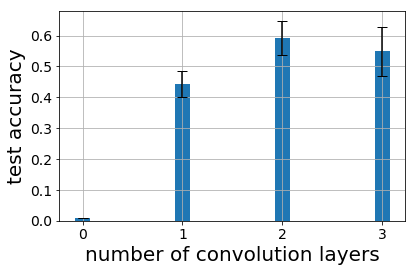

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
width = 0.15       
# ar_auth10_tweets10 = [1.0,1.0,1.0,1.0,1.0]
# ar_auth10_tweets20 = [0.75,0.75,0.5,0.75,0.75]
# ar_auth10_tweets40 = [0.8750,0.8750,0.75,0.875,1.0]
# ar_auth10_tweets60 = [0.8333,0.9167,0.8333,0.8333,0.9167]
sd = [np.mean(acc224_zero),np.mean(acc224_one),np.mean(acc224_two),np.mean(acc224_three)]
asd = [np.std(acc224_zero),np.std(acc224_one),np.std(acc224_two),np.std(acc224_three)]
plt.grid()
plt.bar(['0','1','2','3'], sd, width, label='VGG with attention modules',yerr=asd,capsize=5)
plt.ylabel('test accuracy',fontsize=20)
plt.xlabel('number of convolution layers',fontsize=20)
plt.tight_layout()
plt.savefig("traceability_layer_comparison.jpg")

In [24]:
i = 0
with open('lobster_traceability_vgg16_vanilla'+str(i)+'.hd5','rb') as f:
    model_weights = pickle.load(f)
    print("loading best model")
    base_model.set_weights(model_weights)
    print("loaded best model")
bb = Model(base_model.input,base_model.get_layer('moddel').output)
bb.set_weights(base_model.get_weights()[:-1])

train_dict = convert_to_dict(train_images,train_labels)
test_dict = convert_to_dict(test_images,test_labels)

support_set_preprocessed = {}
for key in train_dict:
    processed = bb.predict(np.array(train_dict[key]))
    support_set_preprocessed[key] = processed
kdash_list = [1,3,5,7,9]
acc = 0
accuracies = []
#hyp = 10
for kdash in kdash_list:
    kdash_list = [1,3,5,7,9]
acc = 0
accuracies = []
#hyp = 10
for kdash in kdash_list:
    acc = 0
    for image,label in zip(test_images,test_labels):
        a = bb.predict(np.expand_dims(image,0))
        #print(label)
        sub_labels = []
        sub_distance = []
        for key in support_set_preprocessed:
            l = []
            for i in support_set_preprocessed[key]:
                l.append(np.linalg.norm(i-a))
            #sub_distance.append(sum(np.sort(l)[:hyp])/hyp)
            sub_distance.append(sum(l)/len(l))
            sub_labels.append(int(key))
        idxl = np.argsort(np.array(sub_distance))[0:kdash]
        lst = np.array(sub_labels)[idxl]
        lst = list(lst)
        #print(lst)
        #print(label)
        if int(label) in lst:
            acc = acc + 1
    accuracies.append(acc/len(test_images))
print(accuracies)

loading best model
loaded best model
[0.5614973262032086, 0.6898395721925134, 0.7433155080213903, 0.7647058823529411, 0.7914438502673797]


In [18]:
i = 0
with open('lobster_traceability_vgg16_vanilla'+str(i)+'.hd5','rb') as f:
    model_weights = pickle.load(f)
    print("loading best model")
    base_model.set_weights(model_weights)
    print("loaded best model")
bb = Model(base_model.input,base_model.get_layer('moddel').output)
bb.set_weights(base_model.get_weights()[:-1])

# support_set_preprocessed = {}
# for key in train_dict:
#     processed = base_model.predict(np.array(train_dict[key]))
#     support_set_preprocessed[key] = processed
kdash_list = [1,3,5,7,9]
acc = 0
accuracies = []
#hyp = 10
for kdash in kdash_list:
    kdash_list = [1,3,5,7,9]
acc = 0
accuracies = []
#hyp = 10
for kdash in kdash_list:
    acc = 0
    for image,label in zip(test_images,test_labels):
        a = base_model.predict(np.expand_dims(image,0))
        #print(label)
#         sub_labels = []
#         sub_distance = []
#         for key in support_set_preprocessed:
#             l = []
#             for i in support_set_preprocessed[key]:
#                 l.append(np.linalg.norm(i-a))
#             #sub_distance.append(sum(np.sort(l)[:hyp])/hyp)
#             sub_distance.append(sum(l)/len(l))
#             sub_labels.append(int(key))
        lst = list(np.argsort(a)[0][::-1][0:kdash])
        #print(lst)
        #print(label)
        #print(label)
        #print(lst)
        inv_lst = le.inverse_transform(lst)
        if label in inv_lst:
            acc = acc + 1
    accuracies.append(acc/len(test_images))
print(accuracies)

loading best model
loaded best model


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[0.5454545454545454, 0.7058823529411765, 0.7914438502673797, 0.8181818181818182, 0.8342245989304813]


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [33]:
np.argsort(a)[0][::-1]

array([103, 108,  14,  28,  53, 101,   7,   8,  94, 111, 112, 107,  92,
        27,  46,  84,   2,  21,  98,  77,  10,  80,  83,  24,  59,  32,
        64,  74,  11,  58,  79,  13,  45,  50,  16,  95,  26,  89,  85,
        19, 100,  31,   4,  75, 102,  54,  37,  56,  34, 110,  23,  68,
        43,  99,  18,   0,  57,   3,  87,  70,  20,  47,  25,  93, 104,
         6,  97,  38,  63,  66, 109,  91,  44,   9,  48,  60,  61,  35,
        15,  41,   5,  81,  51,  17, 105,  29,  78,  30,  67,  40, 106,
        65,  39,   1,  88,  86,  52,  73,  42,  71,  82,  90,  12,  22,
        96,  72,  76,  33,  69,  49,  62,  36,  55])

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


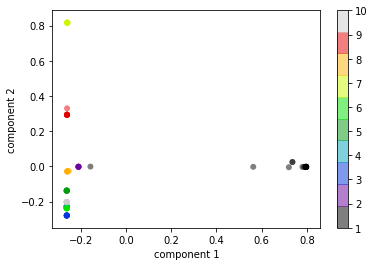

In [22]:
labels = []
features = []
i = 0
for key in support_set_preprocessed:
    i = i + 1
    if (i>10):
        break
    for img in support_set_preprocessed[key]:
        features.append(img)
        labels.append(key)
from sklearn.decomposition import PCA
pca = PCA(2)
projected = pca.fit_transform(features)

plt.scatter(projected[:, 0], projected[:, 1],
            c=labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.savefig('pca_analysis_softmax')

In [20]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
if rotated:
    with open('vgg16-predictions-rotated.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)
else:
    with open('vgg16-predictions.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

NameError: name 'rotated' is not defined

In [39]:
len(test_images)

187

In [ ]:
with open('vgg16-predictions-rotated.pckl','rb') as vgg16:
    train_pred,test_pred,historys,train_scores,test_scores = pickle.load(vgg16)

In [ ]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
idx = 101

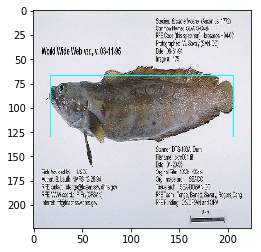

In [36]:
img = test_images[idx]
h,w,cx,cy,angle = testing_bboxes[idx]
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
for xr,yr in rectange_points:
    xr = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr

    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

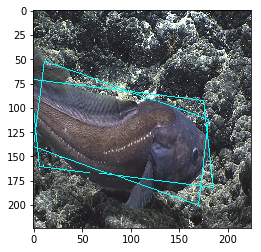

In [28]:
idx = 5
img = test_images[idx]
pts = np.array(test_bboxes[idx])
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [57]:
w,h,cx,cy,angle

(0.9990823, 0.00075547496, 4.3644923e-05, 0.00010419192, 1.4448374e-05)

In [53]:
mod.predict(np.expand_dims(test_images[6],axis=0))

[array([[149.92322 ,  82.941605, 126.17159 , 112.74586 ,  -0.889715]],
       dtype=float32),
 array([[1.1669288e-03, 9.3571018e-08, 7.4474216e-02, 3.6341050e-01,
         5.6094831e-01]], dtype=float32)]

In [16]:
lst = [1,2,3,4,5,6,2]
pred = max(list(lst),key=lst.count)

In [17]:
pred

2